# BLIP 활용한 레이블링

### 2. YOLO와 BLIP 를 다운 받기

In [1]:
from PIL import Image
from ultralytics import YOLO
from transformers.pipelines import pipeline
import torch

ModuleNotFoundError: No module named 'transformers'

In [34]:
# Load pretrained model
yolo_model = YOLO("yolo11x-seg.pt")

https://huggingface.co/docs/transformers/en/model_doc/blip?usage=Pipeline

## YOLO로 객체 분할하기

In [18]:
input_path="test_images/20250708_162328.jpg"

In [101]:
results = yolo_model.predict(input_path, imgsz=(1024, 1024), conf=0.3)
boxes = results[0].boxes.xyxy.cpu().numpy()
# results[0]


image 1/1 /Users/brad/imagegenpoc/test_images/p2.jpg: 480x1024 1 cup, 1 chair, 1 tv, 1 mouse, 1 remote, 2 keyboards, 4734.7ms
Speed: 7.7ms preprocess, 4734.7ms inference, 58.8ms postprocess per image at shape (1, 3, 480, 1024)


In [63]:
boxes

array([[      926.6,      1135.2,      2333.1,      1798.8],
       [     1488.3,      964.23,      2570.4,      1286.2],
       [     2381.1,      845.21,      2676.4,      1115.8],
       [     2382.5,      1319.6,      2686.1,      1520.2],
       [     648.78,      823.52,      979.47,      1354.2],
       [     728.32,      1355.7,      923.23,      1490.3],
       [     434.08,      869.84,      557.81,      998.61],
       [     1440.1,      129.11,      2745.7,      903.33],
       [       2703,      630.08,      3463.6,        1532],
       [     921.51,      686.74,      1161.7,      1074.6],
       [     2701.8,      633.89,      2911.8,      1465.2],
       [     706.89,      696.83,      850.92,      807.54],
       [     538.39,      940.38,      743.67,      1214.1]], dtype=float32)

In [58]:
import matplotlib.pyplot as plt

In [59]:
def show_box(box, ax, color='red'):
    x0, y0, x1, y1 = box  # correct interpretation
    w = x1 - x0
    h = y1 - y0
    rect = plt.Rectangle((x0, y0), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_segmented_images(image, results):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for r in results[0].boxes.data.cpu().numpy():
        show_box(r[:-2], ax)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

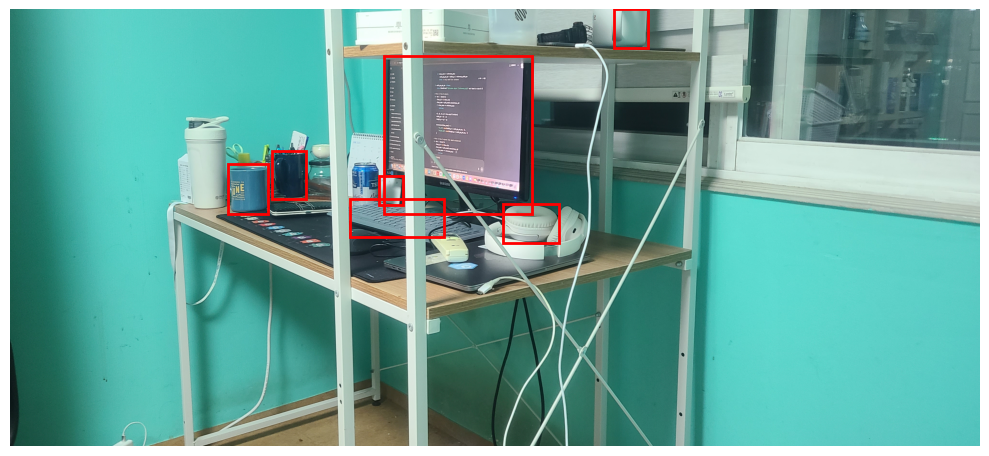

In [107]:
image = Image.open(input_path).convert("RGB")
visualize_segmented_images(image, results)

### 보너스: YOLO-WORLD를 이용한 분할

In [21]:
input_path = "test_images/Professional-Bedroom.png"

In [22]:
from ultralytics import YOLOWorld

# Initialize a YOLO-World model
yolo_model = YOLOWorld("yolov8s-world.pt")

In [23]:


# Execute prediction on an image
results = yolo_model.predict(input_path)

# Show results
results[0].show()


image 1/1 /Users/brad/imagegenpoc/test_images/Professional-Bedroom.png: 320x640 1 bottle, 1 chair, 2 beds, 255.3ms
Speed: 4.2ms preprocess, 255.3ms inference, 2.7ms postprocess per image at shape (1, 3, 320, 640)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### 보너스: API 활용

In [24]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="QheLuA2G6gyN5OgU0f97"
)

result = CLIENT.infer(input_path, model_id="object-detection-not2r/1")

In [27]:
result

{'inference_id': '1bbd2395-d906-4f08-a285-872cc5177533',
 'time': 0.07245157400029711,
 'image': {'width': 1472, 'height': 704},
 'predictions': [{'x': 1333.5,
   'y': 346.0,
   'width': 129.0,
   'height': 156.0,
   'confidence': 0.803676426410675,
   'class': 'Lamp',
   'class_id': 27,
   'detection_id': 'ffba77e0-c157-4157-9978-6518eaaf7911'},
  {'x': 188.5,
   'y': 352.5,
   'width': 375.0,
   'height': 703.0,
   'confidence': 0.5428684949874878,
   'class': 'Wardrobe',
   'class_id': 58,
   'detection_id': 'd5583df6-c8e2-4ed7-93b9-f07e4bbf7d12'}]}

In [35]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def visualize_detections(image_path, predictions):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Load a bold, large font
    try:
        font = ImageFont.truetype("arial.ttf", 28)
    except:
        font = ImageFont.load_default()

    for pred in predictions['predictions']:
        x, y = pred['x'], pred['y']
        w, h = pred['width'], pred['height']
        class_name = pred['class']
        conf = pred['confidence']

        # Bounding box coordinates
        left = x - w / 2
        top = y - h / 2
        right = x + w / 2
        bottom = y + h / 2

        # Draw thicker bounding box
        for offset in range(4):  # simulate thickness
            draw.rectangle(
                [(left - offset, top - offset), (right + offset, bottom + offset)],
                outline="red"
            )

        # Prepare label
        label = f"{class_name} ({conf:.2f})"
        bbox = font.getbbox(label)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Draw label background
        draw.rectangle(
            [left, top - text_height - 8, left + text_width + 8, top],
            fill="red"
        )

        # Draw label text
        draw.text((left + 4, top - text_height - 4), label, fill="white", font=font)

    # Display image
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


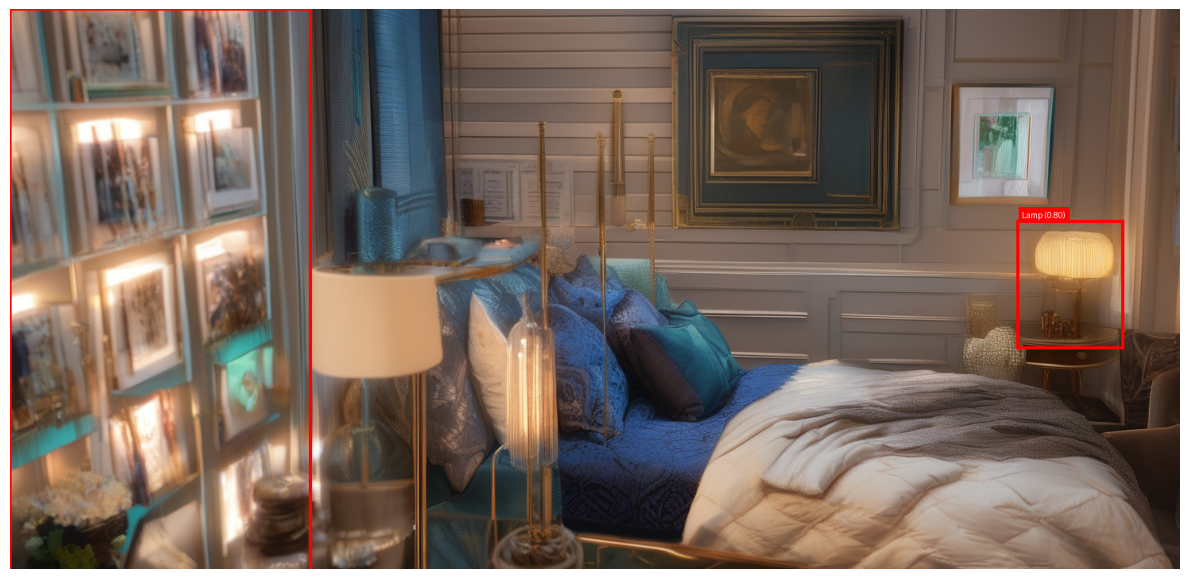

In [36]:
result = CLIENT.infer(input_path, model_id="object-detection-not2r/1")
visualize_detections(input_path, result)

## 이미지 자르고 BLIP 프롬프트를 통한 레이블링

### 이미지 자르기

### BLIP 실행 

In [5]:
import torch
from transformers.pipelines import pipeline

In [6]:
cropping_pipeline = pipeline(
   task="visual-question-answering",
   model="Salesforce/blip-vqa-base",
   torch_dtype=torch.float32,
   device=1,
   
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [11]:
for box in results[0].boxes:
	print(box.xyxy[0].cpu().numpy())

[     707.93      270.21      785.55      486.11]
[          0      447.03      1076.1      2455.3]
[          0      450.72        1080        2506]
[     89.111      330.83      369.49      459.93]


/var/folders/rg/cmtcr_3n3g5bk2x49f7jdpdw0000gn/T/ipykernel_28575/664835132.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(box.cls.cpu().numpy())
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/fold

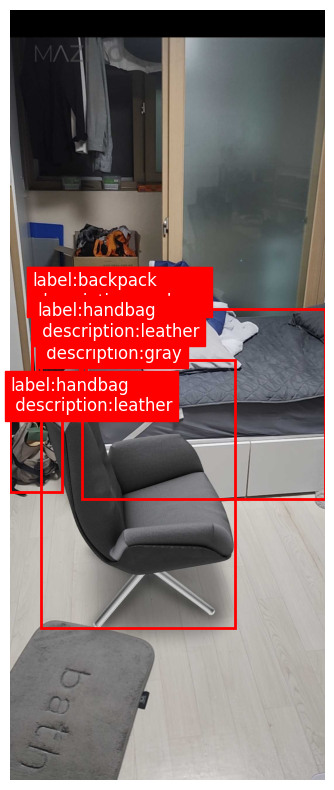

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = Image.open(input_path).convert("RGB")

# Create matplotlib figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

for box in results[0].boxes:
    # Get YOLO label
    class_id = int(box.cls.cpu().numpy())
    label_name = yolo_model.names[class_id]

    # Crop the image
    crop_box = box.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
    cropped = image.crop(crop_box)
    cropped.show()
    # Get BLIP result
    result = cropping_pipeline(
        question=f"Describe the {label_name}'s color, texture, and style, only adjectives.",
        image=cropped,
        generate_kwargs={
            "num_beams": 3,
            "do_sample": False,
        }
    )
    description = result[0].get("answer", "unknown")

    # Draw box and label
    x1, y1, x2, y2 = crop_box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )

    # description = {
    #     "name": label_name,
    #     "description": label
    # }


    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"label:{label_name}\n description:{description}", fontsize=12, color="white", backgroundcolor="red")

plt.axis("off")
plt.tight_layout()
plt.show()
